Change Log:
- v32 - remove building with too large percent error
- v20 - lower learning rate = 0.0008, add height_r and top_floor index
- v16 - change parameters (some from model 05), rm reduce to 68
- v14 - change random seed
- v10 - remove features based on feature importance results (exp-l04-per-area)

### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
model_name = 'model-36-lgb-remove_outlier_03-0.001-2'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
rm_outlier = True
outlier_pct = 3 # 1, 3, 5

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area', 'height_r']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [4]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    # fix town and city
    df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
    df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    # height ratio
    df['height_r'] = df['txn_floor'] / df['total_floor']
    df['top_floor'] = df['txn_floor'] == df['total_floor']
    
    return df  #, cols_feats

In [5]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)


In [6]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [7]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [8]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)
display(train.head(5))
display(test.head(5))

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696


,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,X5gsdTWGS3W7JJQB,1,13,18634,2,4,2,1857,2,NaN,...,7,21,1,129,1,3991,1,8409,1,105.4622312795739
1,BTshNOJyKHnT2YIT,8,7,20199,10,3,2,16011,2,NaN,...,18,44,1,67,1,1950,1,10725,1,100.81980868401074
2,dhdymr0lV8N5kZOT,8,12,19769,4,4,10,18294,2,NaN,...,0,3,1,35,1,3707,1,19459,1,259.8005430183116
3,VEwyGGMcD56w5BOc,10,7,20479,19,2,0,17837,2,NaN,...,16,60,1,144,1,6487,1,29400,1,22.941906168328487
4,wmUeMoJZfsqaSX9b,8,3,18164,13,0,2,13272,2,NaN,...,4,18,1,76,1,1346,1,3280,1,181.21309507601745


In [9]:
# Only train on data in this list
if rm_outlier:
    training_buildings = pd.read_csv('dataset/building_we_care_%d.csv'%outlier_pct)
    print('N outliers removed:', len(train) - len(training_buildings))

N outliers removed: 1800


### Preprocessing

In [10]:
train = pre_processing(train, cols_num, cols_cat)
test = pre_processing(test, cols_num, cols_cat)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

### Remove feats based on shuffle results

In [12]:
# PARS #
N_feats_rm = 70
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],
                         'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

print('N feats (before):', len(cols_feats))
cols_feats = list(set(cols_feats) - set(feats_rm))
print('N feats (after):', len(cols_feats))
print(cols_feats)

[[0 'divorce_rate' 5709.20035 3.333296666667593]
 [1 'I_250' 5709.200316666666 3.333263333333889]
 [2 'XI_100' 5708.200346666667 2.33329333333495]
 [3 'VI_index_500' 5707.867050000001 1.9999966666682667]
 [4 'IX_index_50' 5707.86704 1.9999866666676098]
 [5 'VI_500' 5707.866983333333 1.9999300000008589]
 [6 'XIV_10' 5707.533710000001 1.666656666668132]
 [7 'XI_index_500' 5707.200386666666 1.3333333333339397]
 [8 'VI_index_1000' 5707.200383333334 1.3333300000012969]
 [9 'V_100' 5707.200373333333 1.33332000000064]
 [10 'VII_10' 5707.200363333334 1.333310000001802]
 [11 'X_100' 5707.200336666666 1.3332833333333838]
 [12 'XII_index_50' 5706.867056666667 1.0000033333344618]
 [15 'X_index_500' 5706.867050000001 0.9999966666682667]
 [14 'X_10' 5706.867050000001 0.9999966666682667]
 [13 'II_10' 5706.867050000001 0.9999966666682667]
 [16 'II_index_500' 5706.867046666666 0.9999933333338049]
 [17 'V_index_1000' 5706.867046666666 0.9999933333338049]
 [18 'XIII_10' 5706.867043333335 0.99999000000207

### Params

In [13]:
# params
# parameters from model 10: 24, 300, 0.5, 10, 0.1, 0.0
# parameters from model 5: 24, 258, 0.4, 6, 0.04, 0.02
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'mse',
          'metric': 'mape',
          'learning_rate': 0.001, # 0.001
          'max_depth': 24,
          'num_leaves': 279,           # may reduce in dim-reduction exp
          'feature_fraction': 0.45,
          'min_data_in_leaf': 8,
          'lambda_l1': 0.07,
          'lambda_l2': 0.01,
          'seed': 666,
          'bagging_freq': 8,
          'bagging_fraction': 0.8, 
         }

lgb_other_params = {'num_boost_round': 1000000,  # expected to stop 250000
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,}


### kfold cross-predict

In [14]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
best_iterations = []
scores = []
for i, id_fold in enumerate(id_cv):
    #id_fold = id_fold['building_id']
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy()
    df_val = train.loc[train['building_id'].isin(id_fold)].copy()
    df_test = test.copy()
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    if rm_outlier:
        df_train = df_train.merge(training_buildings, on='building_id', how='inner').reset_index()

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()
        
    # train model    
    model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params, keep_training_booster=True)
    best_iterations.append(model.best_iteration)

    # Predict on val set
    y_pred = model.predict(df_val[cols_feats])
    mse = mean_squared_error(df_val[col_target], y_pred)
    mae = mean_absolute_error(df_val[col_target], y_pred)
    mape = cal_mape(df_val[col_target], y_pred)
    
    y_pred_final = post_processing(y_pred, df_val)
    score = cal_score(df_val['total_price'], y_pred_final)
    scores.append(score)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': y_pred_final}))

    # Predict on test set
    y_pred_test = model.predict(df_test[cols_feats])
    predicts_test['target_{}'.format(i)] = y_pred_test

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0157146
[4000]	valid_0's mape: 0.0113885
[6000]	valid_0's mape: 0.010458
[8000]	valid_0's mape: 0.0100364
[10000]	valid_0's mape: 0.00979119
[12000]	valid_0's mape: 0.00962742
[14000]	valid_0's mape: 0.00951067
[16000]	valid_0's mape: 0.0094228
[18000]	valid_0's mape: 0.00935455
[20000]	valid_0's mape: 0.00929887
[22000]	valid_0's mape: 0.00925367
[24000]	valid_0's mape: 0.00921663
[26000]	valid_0's mape: 0.00918505
[28000]	valid_0's mape: 0.0091584
[30000]	valid_0's mape: 0.00913602
[32000]	valid_0's mape: 0.00911559
[34000]	valid_0's mape: 0.00909842
[36000]	valid_0's mape: 0.00908298
[38000]	valid_0's mape: 0.0090694
[40000]	valid_0's mape: 0.00905713
[42000]	valid_0's mape: 0.00904598
[44000]	valid_0's mape: 0.00903647
[46000]	valid_0's mape: 0.0090277
[48000]	valid_0's mape: 0.00901991
[50000]	valid_0's mape: 0.0090124
[52000]	valid_0's mape: 0.0090055
[54000]	valid_0's mape: 0.00899933
[56000

[152000]	valid_0's mape: 0.00896463
[154000]	valid_0's mape: 0.00896429
[156000]	valid_0's mape: 0.00896399
[158000]	valid_0's mape: 0.00896367
[160000]	valid_0's mape: 0.00896339
[162000]	valid_0's mape: 0.00896315
[164000]	valid_0's mape: 0.00896288
[166000]	valid_0's mape: 0.00896264
[168000]	valid_0's mape: 0.00896234
[170000]	valid_0's mape: 0.00896214
[172000]	valid_0's mape: 0.00896189
[174000]	valid_0's mape: 0.00896163
[176000]	valid_0's mape: 0.0089614
[178000]	valid_0's mape: 0.0089612
[180000]	valid_0's mape: 0.008961
[182000]	valid_0's mape: 0.00896081
[184000]	valid_0's mape: 0.00896062
[186000]	valid_0's mape: 0.00896039
[188000]	valid_0's mape: 0.00896022
[190000]	valid_0's mape: 0.00896007
[192000]	valid_0's mape: 0.00895988
[194000]	valid_0's mape: 0.00895969
[196000]	valid_0's mape: 0.00895953
[198000]	valid_0's mape: 0.00895941
[200000]	valid_0's mape: 0.00895924
[202000]	valid_0's mape: 0.0089591
[204000]	valid_0's mape: 0.00895898
[206000]	valid_0's mape: 0.008958

[274000]	valid_0's mape: 0.00898857
[276000]	valid_0's mape: 0.00898849
[278000]	valid_0's mape: 0.00898843
[280000]	valid_0's mape: 0.00898834
[282000]	valid_0's mape: 0.00898827
[284000]	valid_0's mape: 0.00898818
[286000]	valid_0's mape: 0.00898811
[288000]	valid_0's mape: 0.00898804
[290000]	valid_0's mape: 0.00898796
[292000]	valid_0's mape: 0.00898788
[294000]	valid_0's mape: 0.00898779
[296000]	valid_0's mape: 0.00898772
[298000]	valid_0's mape: 0.00898769
[300000]	valid_0's mape: 0.00898762
[302000]	valid_0's mape: 0.00898755
[304000]	valid_0's mape: 0.00898748
[306000]	valid_0's mape: 0.00898741
[308000]	valid_0's mape: 0.00898737
[310000]	valid_0's mape: 0.00898732
[312000]	valid_0's mape: 0.00898727
[314000]	valid_0's mape: 0.00898722
[316000]	valid_0's mape: 0.00898716
[318000]	valid_0's mape: 0.00898713
[320000]	valid_0's mape: 0.00898707
[322000]	valid_0's mape: 0.00898701
[324000]	valid_0's mape: 0.00898696
[326000]	valid_0's mape: 0.00898692
[328000]	valid_0's mape: 0.0

[356000]	valid_0's mape: 0.00901028
[358000]	valid_0's mape: 0.00901024
[360000]	valid_0's mape: 0.00901019
[362000]	valid_0's mape: 0.00901016
[364000]	valid_0's mape: 0.00901011
[366000]	valid_0's mape: 0.00901008
[368000]	valid_0's mape: 0.00901003
[370000]	valid_0's mape: 0.00900996
[372000]	valid_0's mape: 0.00900992
[374000]	valid_0's mape: 0.00900985
[376000]	valid_0's mape: 0.00900981
[378000]	valid_0's mape: 0.00900978
[380000]	valid_0's mape: 0.00900972
[382000]	valid_0's mape: 0.00900967
[384000]	valid_0's mape: 0.00900962
[386000]	valid_0's mape: 0.00900958
[388000]	valid_0's mape: 0.00900957
[390000]	valid_0's mape: 0.00900956
[392000]	valid_0's mape: 0.0090095
[394000]	valid_0's mape: 0.00900946
[396000]	valid_0's mape: 0.00900942
[398000]	valid_0's mape: 0.00900937
Early stopping, best iteration is:
[398074]	valid_0's mape: 0.00900937
(Fold 3) score, mse, mae, mape: 6002.87670, 0.03717, 0.11996, 0.00901.
Training until validation scores don't improve for 1000 rounds.
[20

42s per 2000 - ETA (all): 1,924,664 iters = 11.2 hours

In [15]:
print('Total run time:', time.time() - t0)

Total run time: 54230.25604391098


In [16]:
print('Kfold cv score (mean, stdev):', np.mean(scores), np.std(scores)) # 5868.87314

Kfold cv score (mean, stdev): 5989.876236269576 37.76727622440563


In [17]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,15.109804,15.131989,15.101721,15.174467,15.075277
1,BTshNOJyKHnT2YIT,13.137399,13.113963,13.131788,13.132877,13.135185
2,dhdymr0lV8N5kZOT,13.645404,13.667705,13.664046,13.641253,13.662108
3,VEwyGGMcD56w5BOc,14.820473,14.824438,14.788890,14.830765,14.784735
4,wmUeMoJZfsqaSX9b,12.141522,12.123945,12.072386,12.176731,12.175978


In [18]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [19]:
print('Best iterations:', best_iterations)
print('Mean best iterations:', int(np.mean(best_iterations)))

Best iterations: [297368, 328539, 366008, 398074, 251513]
Mean best iterations: 328300


### One-fold test

In [20]:
lgb_other_params_one = {'num_boost_round': int(np.mean(best_iterations)*1.2),
                        'verbose_eval': 2000,}
lgb_other_params_one

{'num_boost_round': 393960, 'verbose_eval': 2000}

In [21]:
params

{'task': 'train',
 'boosting_type': 'gbdt',
 'objective': 'mse',
 'metric': 'mape',
 'learning_rate': 0.001,
 'max_depth': 24,
 'num_leaves': 279,
 'feature_fraction': 0.45,
 'min_data_in_leaf': 8,
 'lambda_l1': 0.07,
 'lambda_l2': 0.01,
 'seed': 666,
 'bagging_freq': 8,
 'bagging_fraction': 0.8}

In [22]:
t10 = time.time()

df_train = train.copy()
df_test = test.copy()

# feat eng
feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
df_train = feat_eng.fit_transform(df_train)
df_test = feat_eng.transform(df_test)

if rm_outlier:
    df_train = df_train.merge(training_buildings, on='building_id', how='inner').reset_index()

# Construct lgb dataset
lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()

# train model    
model = lgb.train(params, lgb_train, valid_sets=lgb_train, **lgb_other_params_one, keep_training_booster=True)

y_pred = model.predict(df_test[cols_feats])
y_pred_final = post_processing(y_pred, df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': y_pred_final})

t11 = time.time()

display(df_test_pred.head(20))

[2000]	training's mape: 0.0135856
[4000]	training's mape: 0.00831374
[6000]	training's mape: 0.0068711
[8000]	training's mape: 0.00603266
[10000]	training's mape: 0.00542991
[12000]	training's mape: 0.00496225
[14000]	training's mape: 0.00458192
[16000]	training's mape: 0.00425746
[18000]	training's mape: 0.00397963
[20000]	training's mape: 0.00373222
[22000]	training's mape: 0.00351371
[24000]	training's mape: 0.00331732
[26000]	training's mape: 0.00313851
[28000]	training's mape: 0.00297603
[30000]	training's mape: 0.00282747
[32000]	training's mape: 0.00269055
[34000]	training's mape: 0.00256302
[36000]	training's mape: 0.0024455
[38000]	training's mape: 0.00233714
[40000]	training's mape: 0.00223547
[42000]	training's mape: 0.0021408
[44000]	training's mape: 0.00205278
[46000]	training's mape: 0.0019702
[48000]	training's mape: 0.00189228
[50000]	training's mape: 0.0018189
[52000]	training's mape: 0.00174925
[54000]	training's mape: 0.00168394
[56000]	training's mape: 0.00162278
[5

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.298618e+07
1,BTshNOJyKHnT2YIT,3.897411e+06
2,dhdymr0lV8N5kZOT,1.049745e+07
3,VEwyGGMcD56w5BOc,6.139949e+06
4,wmUeMoJZfsqaSX9b,1.106728e+06
5,EtBjGAHmHCe9t7TZ,2.765256e+06
6,hPNH34vmaZtvBtqc,1.220507e+07
7,wXjeI38bYDMJJwZC,6.279981e+06
8,fxZSGX6aPAFKU8W4,1.676985e+06
9,ewr0Fx6ign87OwaV,4.063025e+06


In [23]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

In [24]:
print('Total run time:', t11 - t10)

Total run time: 10206.89031291008


### Feature importance

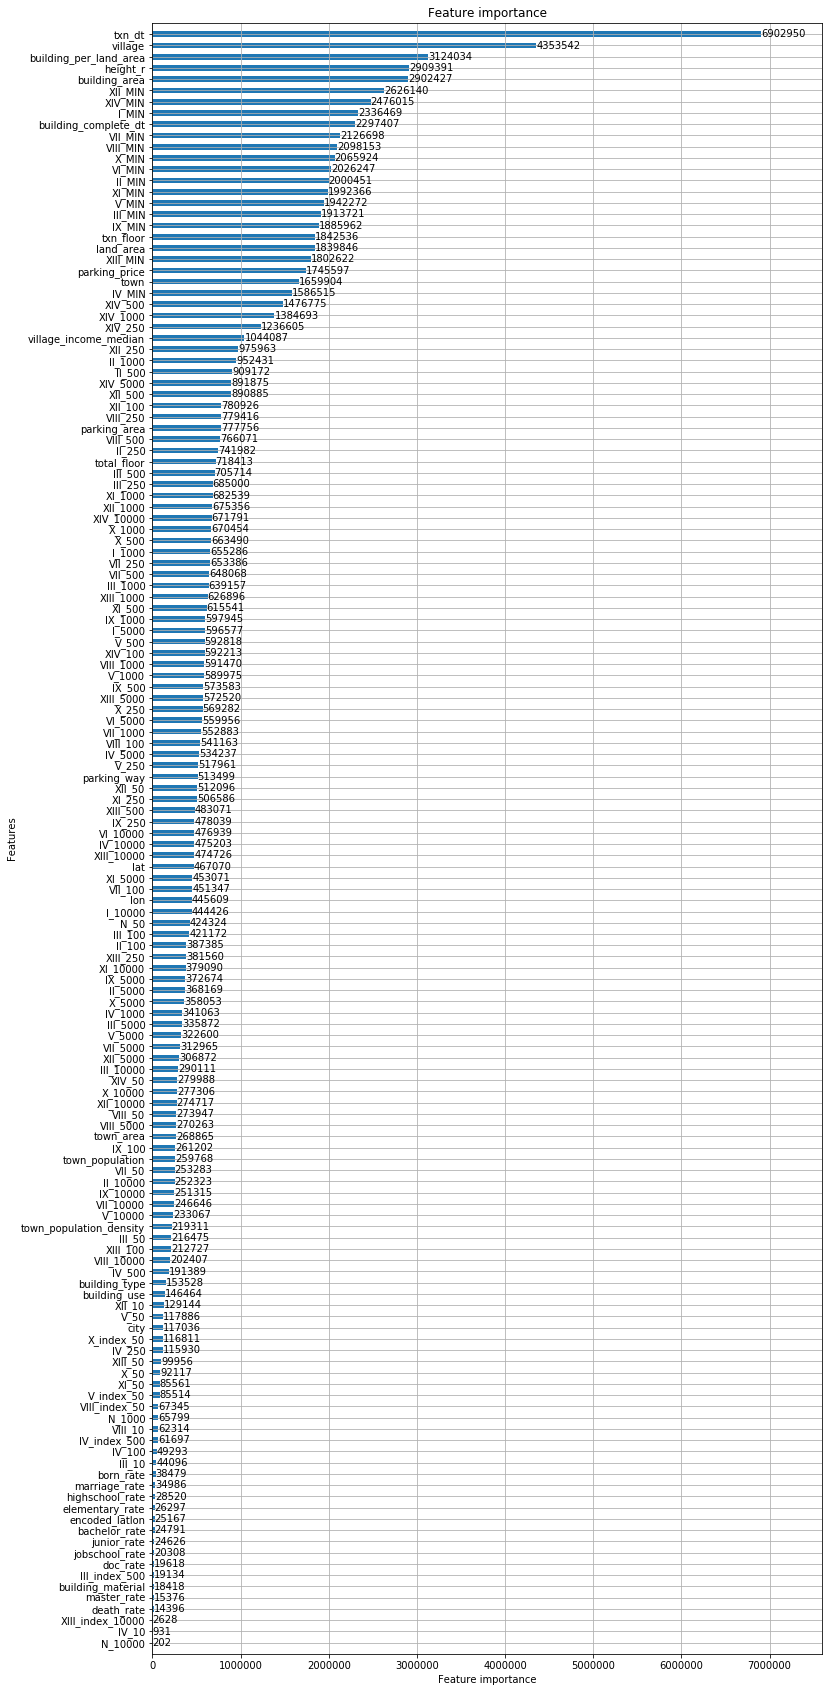

In [25]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

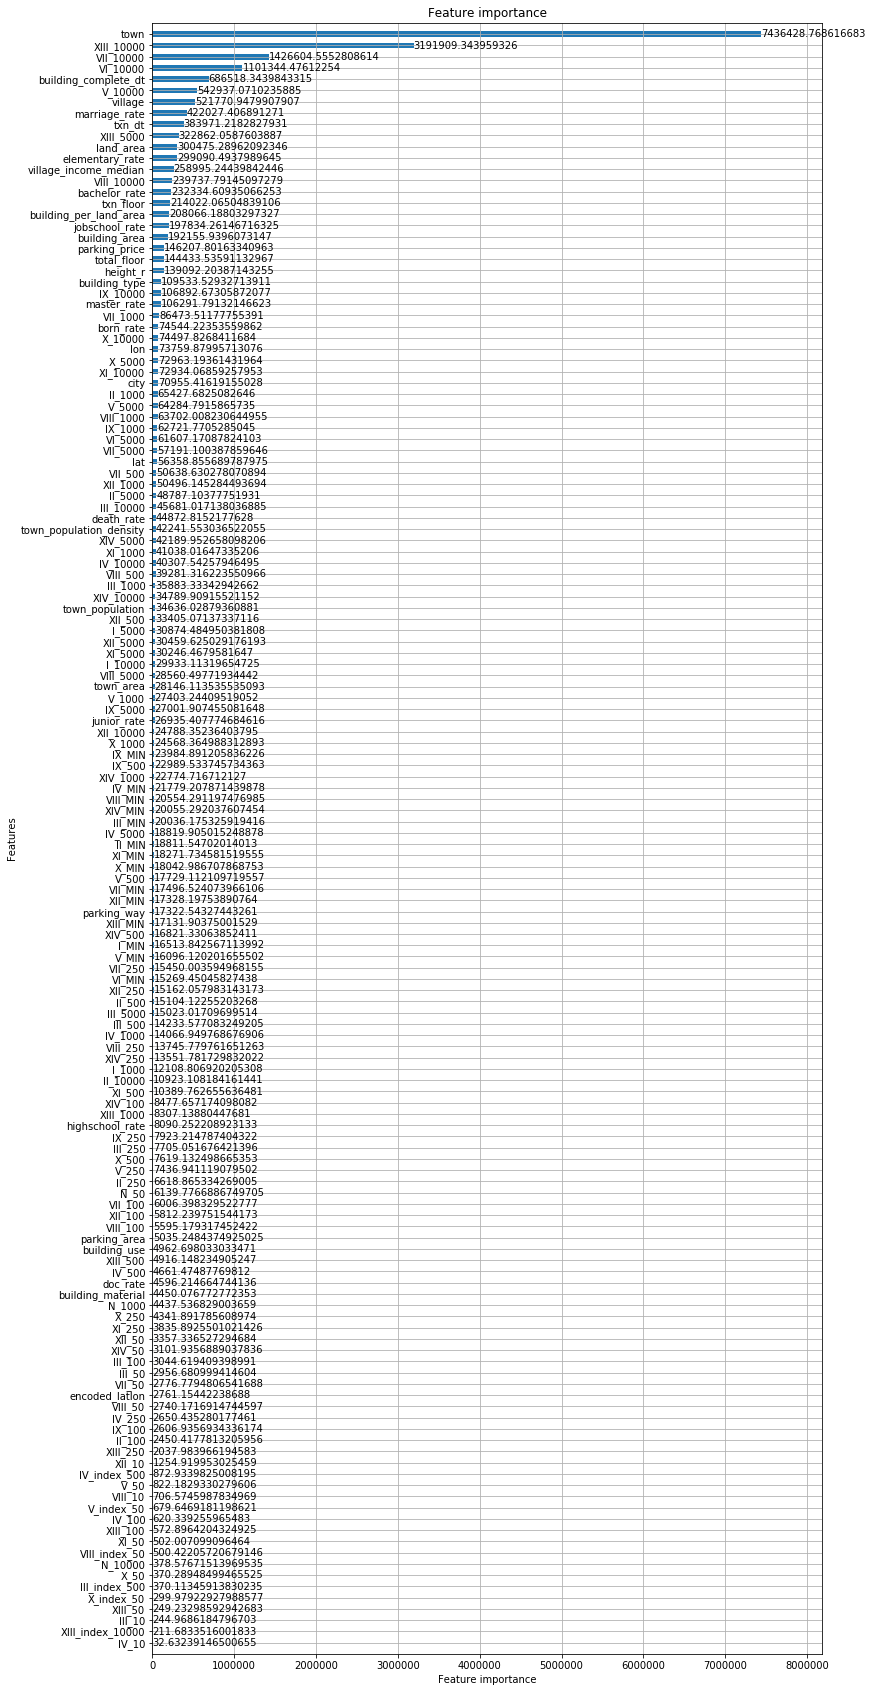

In [26]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()